In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

### Import package

In [4]:
import sys
import os
sys.path.append('../')
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Data cleaning").getOrCreate()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from yaml import load as yaml_load

### Import classes from src

In [5]:
from src.data.make_dataset import LoadDataframe
from src.features.build_features import extract_features_regression
from src.models.train_model import model_regression

### Functions to load yaml file configuration

In [6]:
def _load_config_file(config_file):
    """
    Load configuration file
    :param config_file: is the configuration file
    :return: configuration
    :rtype: dict
    """
    with open(config_file) as yml_config:
        return yaml_load(yml_config)

def _build_configuration(config_file):
    """
    Build the operation configuration dict
    :param config_file: is the path to the yaml config_file
    :type: string
    :return: config: global configuration
    :rtype dict
    """
    # yaml config
    config = _load_config_file(config_file)
    return config


In [7]:
def visualisation_prediction(y_test, y_pred):
    import matplotlib.pyplot as plt
    import matplotlib
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30) 
    fig, ax = plt.subplots(figsize=(50, 40))
    plt.style.use('ggplot')
    plt.plot(y_pred, y_test, 'ro')
    plt.xlabel('Predicted Crime', fontsize = 30)
    plt.ylabel('Actual Crime', fontsize = 30)
    plt.title('Predicted Y (Crimes) to the Actual Y (Crimes)', fontsize = 30)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

### Loads yaml file configuration

In [46]:
config_file = "/home/ml/Documents/Crime_Chigaco_Spark/config/config.yml"
config = _build_configuration(config_file)

### Loads  LoadDataframe class, for more informations you can use help(LoadDataframe)

In [10]:
%%time
obj_df_loaded = LoadDataframe(config, '2012', '2013')

CPU times: user 361 µs, sys: 27 µs, total: 388 µs
Wall time: 393 µs


In [11]:
df_nb_crimes = obj_df_loaded.df_nb_crimes()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [12]:
df_nb_crimes.limit(5).toPandas().T

,0,1,2,3,4
community_area_number,10,11,13,16,17
month,10,10,12,2,10
year,2012,2012,2012,2012,2012
primary_type,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,LIQUOR LAW VIOLATION,DECEPTIVE PRACTICE,NARCOTICS
nb_crimes,9,19,1,7,8
community_area_name,Norwood Park,Jefferson Park,North Park,Irving Park,Dunning
pct_housing_crowded,2,2.7,3.9,6.3,5.2
pct_households_below_poverty,5.4,8.6,13.2,13.1,10.6
pct_age16_unemployed,9,12.4,9.9,10,10
pct_age25_no_highschool,11.5,13.4,14.4,22.4,16.2


In [13]:
obj_extract_features_regression =  extract_features_regression(config, df_nb_crimes)

In [14]:
df_ml = obj_extract_features_regression.extract_feature()

In [15]:
df_crime = obj_df_loaded.df_crime()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [16]:
df_ml.printSchema()

root
 |-- label: long (nullable = false)
 |-- pct_housing_crowded: double (nullable = false)
 |-- pct_households_below_poverty: double (nullable = false)
 |-- pct_age16_unemployed: double (nullable = false)
 |-- pct_age25_no_highschool: double (nullable = false)
 |-- pct_not_working_age: double (nullable = false)
 |-- per_capita_income: double (nullable = false)
 |-- hardship_index: double (nullable = false)
 |-- primary_type_ARSON: long (nullable = true)
 |-- primary_type_CRIM SEXUAL ASSAULT: long (nullable = true)
 |-- primary_type_CRIMINAL DAMAGE: long (nullable = true)
 |-- primary_type_CRIMINAL TRESPASS: long (nullable = true)
 |-- primary_type_DECEPTIVE PRACTICE: long (nullable = true)
 |-- primary_type_GAMBLING: long (nullable = true)
 |-- primary_type_HOMICIDE: long (nullable = true)
 |-- primary_type_INTERFERENCE WITH PUBLIC OFFICER: long (nullable = true)
 |-- primary_type_INTIMIDATION: long (nullable = true)
 |-- primary_type_KIDNAPPING: long (nullable = true)
 |-- primary_t

In [17]:
obj_model_regression = model_regression(config, df_ml)

In [18]:
model = obj_model_regression.train_gbt()

### the model will be tested on 2014 data

In [19]:
%%time
obj_df_loaded_2014 = LoadDataframe(config, '2014', '2015')

CPU times: user 243 µs, sys: 29 µs, total: 272 µs
Wall time: 275 µs


### Loads data for testing

In [20]:
df_nb_crimes_2014 = obj_df_loaded.df_nb_crimes()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


### Extract features for 2014 data

In [21]:
obj_extract_features_regression_2014 =  extract_features_regression(config, df_nb_crimes_2014)
df_ml_2014 = obj_extract_features_regression_2014.extract_feature()

### Prediction

In [22]:
predictions = model.transform(df_ml_2014)

### Show some results

In [23]:
prediction_df = predictions.select('label','prediction').toPandas()

## Score 

In [24]:
predictions.printSchema()

root
 |-- label: long (nullable = false)
 |-- pct_housing_crowded: double (nullable = false)
 |-- pct_households_below_poverty: double (nullable = false)
 |-- pct_age16_unemployed: double (nullable = false)
 |-- pct_age25_no_highschool: double (nullable = false)
 |-- pct_not_working_age: double (nullable = false)
 |-- per_capita_income: double (nullable = false)
 |-- hardship_index: double (nullable = false)
 |-- primary_type_ARSON: long (nullable = true)
 |-- primary_type_CRIM SEXUAL ASSAULT: long (nullable = true)
 |-- primary_type_CRIMINAL DAMAGE: long (nullable = true)
 |-- primary_type_CRIMINAL TRESPASS: long (nullable = true)
 |-- primary_type_DECEPTIVE PRACTICE: long (nullable = true)
 |-- primary_type_GAMBLING: long (nullable = true)
 |-- primary_type_HOMICIDE: long (nullable = true)
 |-- primary_type_INTERFERENCE WITH PUBLIC OFFICER: long (nullable = true)
 |-- primary_type_INTIMIDATION: long (nullable = true)
 |-- primary_type_KIDNAPPING: long (nullable = true)
 |-- primary_t

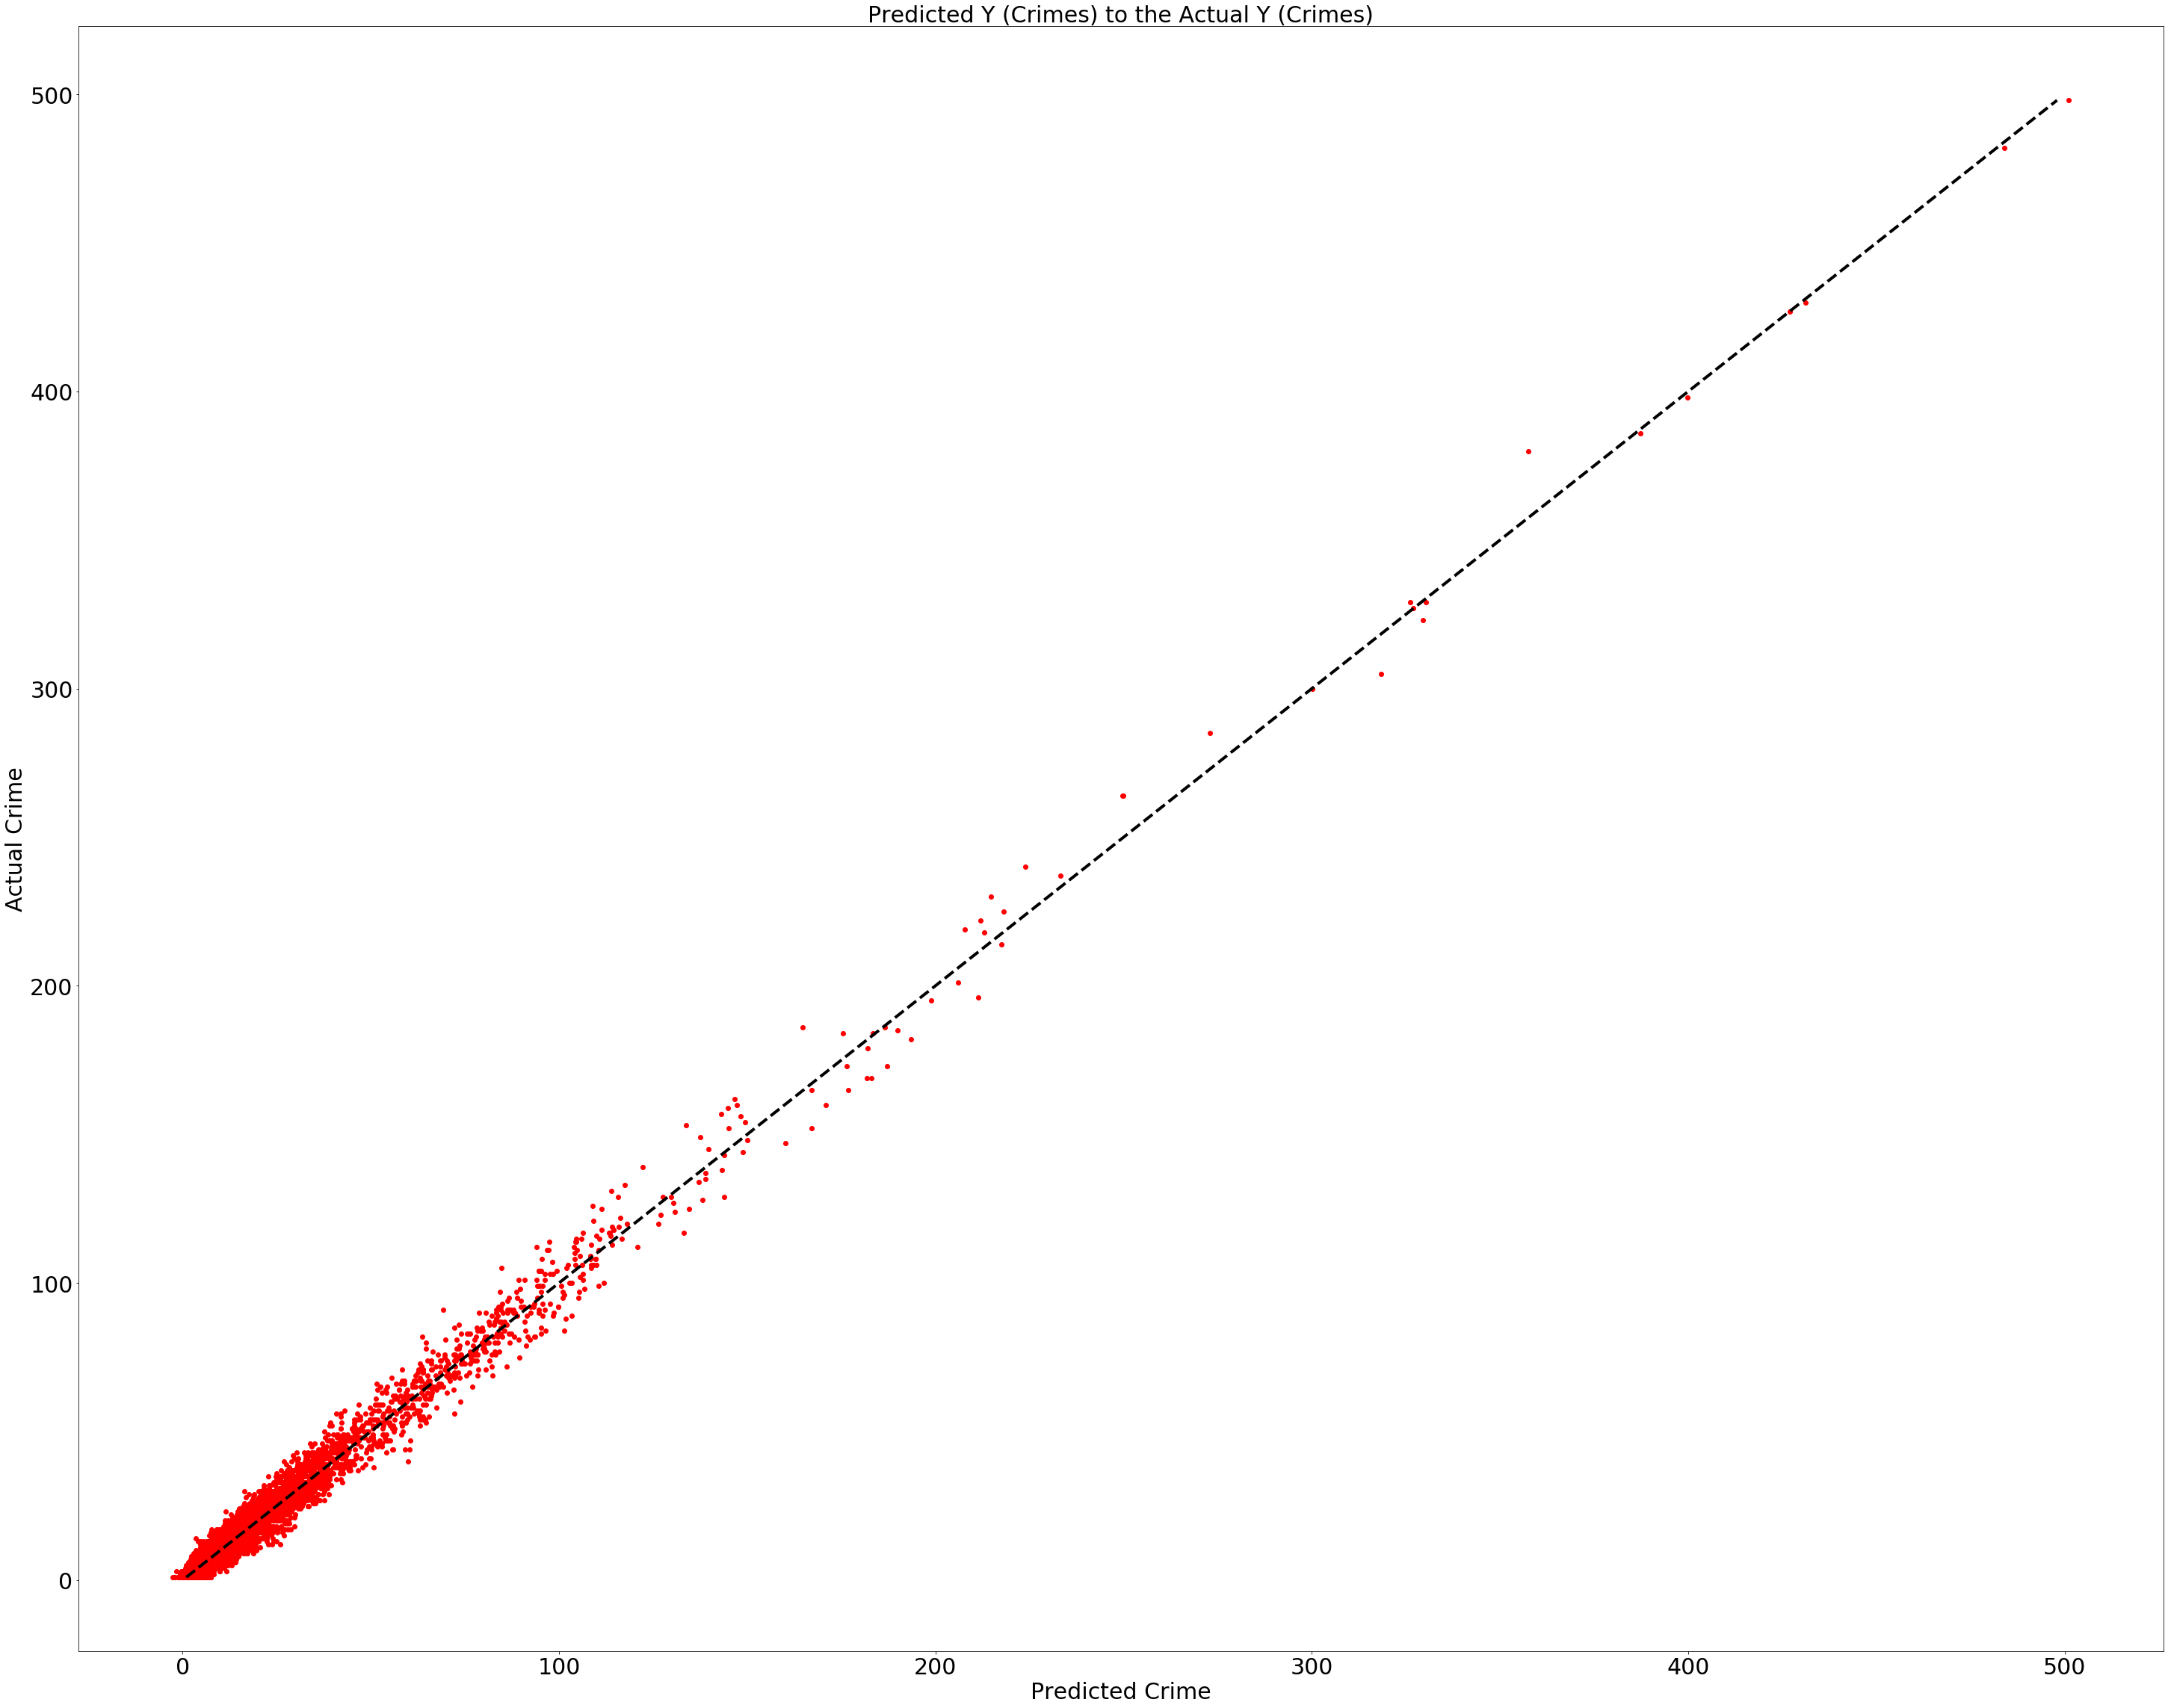

In [25]:
visualisation_prediction(prediction_df['label'], prediction_df['prediction'])

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error


In [28]:
r2_score(prediction_df['label'], prediction_df['prediction'])

0.9857001756955994

In [29]:
columns_to_filter = ['primary_type_NARCOTICS', 'community_area_name_Austin', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',\
              'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'label', 'prediction']


In [30]:
df = predictions.select(*columns_to_filter).toPandas()

In [31]:
df.sample(5)

,primary_type_NARCOTICS,community_area_name_Austin,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,label,prediction
10169,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1.768703
6791,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,5.037399
9309,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,8.076951
4286,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,11.539846
1414,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,6.603262


In [33]:
df = df[(df['primary_type_NARCOTICS']==1) & (df['community_area_name_Austin']==1)]

In [34]:
df.sample(5)

,primary_type_NARCOTICS,community_area_name_Austin,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,label,prediction
10081,1,1,0,0,1,0,0,0,0,0,0,0,0,0,482,484.093183
6389,1,1,0,1,0,0,0,0,0,0,0,0,0,0,498,501.035643
5495,1,1,0,0,0,0,0,0,1,0,0,0,0,0,398,399.764874
9066,1,1,0,0,0,0,0,0,0,0,1,0,0,0,329,330.312477
3676,1,1,0,0,0,0,0,0,0,1,0,0,0,0,323,329.455118


In [42]:
month = ['janvier', 'novembre','avril','aout','decembre','juielet','juillet', 'aout','octobre','septembte','juin','mars']

In [43]:
df['month'] = month
df.set_index('month', inplace=True)

In [44]:
df.head(15)

,primary_type_NARCOTICS,community_area_name_Austin,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,label,prediction
month,,,,,,,,,,,,,,,,
janvier,1,1,1,0,0,0,0,0,0,0,0,0,0,0,430,431.208191
novembre,1,1,0,0,0,0,0,0,0,0,0,0,1,0,327,326.972142
avril,1,1,0,0,0,1,0,0,0,0,0,0,0,0,427,426.997282
aout,1,1,0,0,0,0,0,0,0,1,0,0,0,0,323,329.455118
decembre,1,1,0,0,0,0,0,0,0,0,0,0,0,1,329,326.171593
juielet,1,1,0,0,0,0,0,0,1,0,0,0,0,0,398,399.764874
juillet,1,1,0,1,0,0,0,0,0,0,0,0,0,0,498,501.035643
aout,1,1,0,0,0,0,1,0,0,0,0,0,0,0,380,357.632062
octobre,1,1,0,0,0,0,0,0,0,0,0,1,0,0,305,318.466720


In [55]:
import pandas as pd
import numpy as np

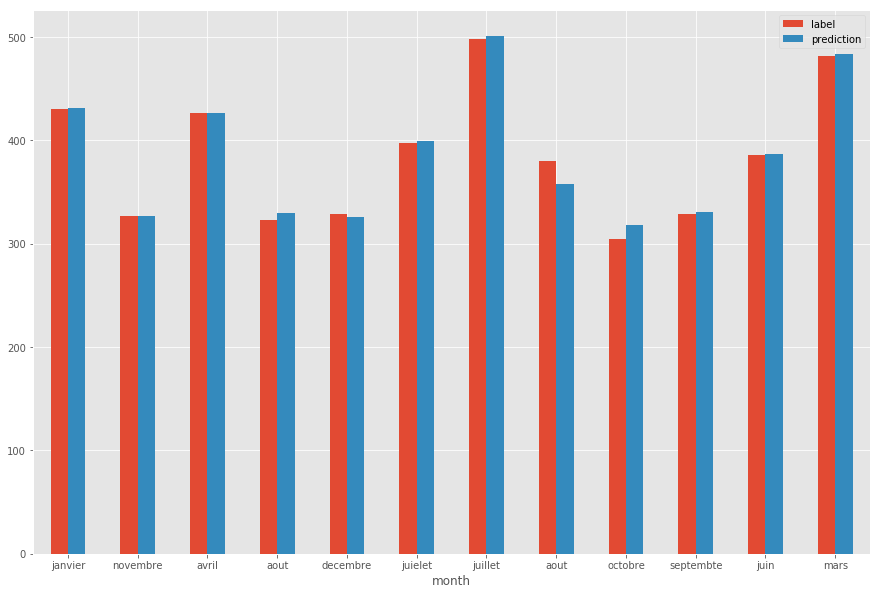

In [45]:
ax = df[['label', 'prediction']].plot.bar(rot=0, figsize=(15,10), fontsize=10)